# `PyTorch` for Deep Learning

<a target="_blank" href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/notebooks/Lab-11.Pytorch_NN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE**: This notebook is the same as the *non-solved* version.


In the following Lab, we will learn how to define, train and evaluate a *Neural Network* model in PyTorch. We will use a simple *Convolutional Neural Network* as an example, and we will train it on the *MNIST* dataset.

In [1]:

import torch
import torch.nn as nn # basic building blocks for graphs
import torch.nn.functional as F # dropout, loss, activation functions, and more
import torchvision # popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms # common image transformations

import matplotlib.pyplot as plt
import numpy as np
from time import time


In [2]:
# avoids the notebook from dying

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
device

device(type='cuda')

## Intro to PyTorch

`PyTorch` is a Python/C++-based *Deep Learning* and *scientific computing* package that mainly provides two high-level features:  
* **Tensor computation** (like `NumPy`) with strong GPU acceleration 
* **Deep neural networks** built on an **autograd** system ([more info](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html))

The flexibility of `PyTorch` and its *Pythonic* interfaces make it the most widely adopted framework for research and development, both in academia and industry.

For more info, you can have a look at the [official documentation](https://pytorch.org/docs/stable/index.html) or refer to [this book](https://isip.piconepress.com/courses/temple/ece_4822/resources/books/Deep-Learning-with-PyTorch.pdf).

Fun fact: *PyTorch was first created by Meta AI in 2016, and is now the base for Tesla's autopilot!* 

Like NumPy, PyTorch provides its own multidimensional array class, called `Tensor`. `Tensor`s are essentially the equivalent of NumPy `ndarray`s.
* `Tensor` draws a lot of methods from NumPy
* `Tensor` has CUDA support (faster!)

In [5]:
# create custom Tensor and ndarray
x = torch.Tensor([[1,5,4],[3,2,1]])
y = np.array([[1,5,4],[3,2,1]])

def pretty_print(obj, title=None):
    if title is not None:
        print(title)
    print(obj)
    print("\n")

pretty_print(x, "x")
pretty_print(y, "y")

x
tensor([[1., 5., 4.],
        [3., 2., 1.]])


y
[[1 5 4]
 [3 2 1]]




What are these types of objects?

In [6]:
print(x.dtype)
print(y.dtype)

torch.float32
int32


`torch` already thinks with Machine Learning in mind as the `Tensor` is implicitly converted to `dtype float32`, while NumPy makes no such assumption.

For more info on `Tensor` data types, check the beginning of [this page](https://pytorch.org/docs/stable/tensors.html).

As in NumPy, we can call the `.shape` attribute to get the shape of the structures. Moreover, `Tensor`s have also the `.size()` method which is analogous to `.shape`.

In [7]:
print(x.shape)
print(y.shape)
print(x.size())

torch.Size([2, 3])
(2, 3)
torch.Size([2, 3])


Notice how a `Tensor` shape is **not** a tuple.

We can also create a random `Tensor` analogously to NumPy.

A `2 × 3 × 3` `Tensor` is the same as saying "2 3 × 3 matrices", or a "cubic matrix"

In [8]:
x = torch.rand([2, 3, 3])
x

tensor([[[0.8931, 0.4185, 0.6170],
         [0.1469, 0.3416, 0.0059],
         [0.5788, 0.1549, 0.2428]],

        [[0.3315, 0.2953, 0.9087],
         [0.0540, 0.6949, 0.4863],
         [0.1144, 0.0938, 0.3784]]])

## Training a simple *Convolutional Neural Network* on the *MNIST* dataset


In [9]:
# A good idea is to start with ~32 (Masters and Luschi, 2018 | https://arxiv.org/abs/1804.07612)
BATCH_SIZE = 32

### Getting and loading the data
There are potentially other -- more *handcrafted* -- ways to load the data. However, it is always a good practice to rely on `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes, as they provide many useful functionalities, such as automated *batching*, *shuffling*, loading *parallelization* and *data augmentation* (`transforms`).

In [10]:
# Convert data to PyTorch tensor form 
data_transforms = transforms.ToTensor()

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

### Visualising the data
Let's have a look at some of the images in the data set.

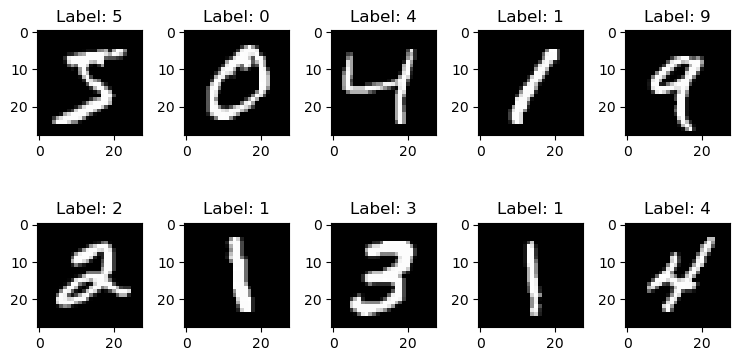

In [11]:
num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainset.targets[i]))
plt.tight_layout()
plt.show()

In [12]:
# printing data shapes 
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


### Defining the model

In `PyTorch`, we define a model by subclassing the `nn.Module` class and defining the `forward` method. The `forward` method is where we define the *computation* that happens at every *forward pass* of the model.

Except for extreme corner-cases, the backward pass is automatically defined by `PyTorch` *autograd* system and gradients are obtained efficiently whenever needed.

`PyTorch` modules are *transparent* with respect to batch sizes, i.e. we can use the same model to process a single sample or a batch of samples, without worrying about the exact batch size.

In [13]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.l1 = nn.Linear(32 * 26 * 26, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # flatten => BS x (32*26*26) = BS x 21632
        x = x.flatten(start_dim = 1)

        # BSx(32*26*26) => BSx128
        x = self.l1(x)

        x = F.relu(x)

        # BSx128 => BSx10
        logits = self.l2(x)

        # Softmax computation
        out = F.softmax(logits, dim=1)
        
        return out

#you can get the same result with torch.nn.sequential
#easier, but less flexible

model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )

### Model instantiation and test with a single batch
We haven't trained the model yet, so it's not going to give us good results. However, we can still test it on a single batch of data to see if it works from the implementation viewpoint.

In [14]:
model = MyModel()
out = model(images)
print(f"Output shape is: {out.shape}  i.e.: batch_size x num_classes")

Output shape is: torch.Size([32, 10])  i.e.: batch_size x num_classes


In [15]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

print(f"Accuracy on the single batch just used: {get_batch_accuracy(out, labels)}%")

Accuracy on the single batch just used: 12.5%


In [16]:
# Device selection if you have a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If you are a rich Mac user
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Re-instantiate the model to reset the weights/gradients. 
# Weights are initialized by default according to Kaiming He et al. (2015) | https://arxiv.org/abs/1502.01852
model = MyModel()  
model = model.to(device)  # Move the model to the selected device

print(f"Using device: {device}")

Using device: cuda


In [17]:
# Number of times the whole (training) dataset is used for training
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training loop
**if you are running in colab**

Using `CPU`, this training loop is very slow. We can run it on [GPU](https://cloud.google.com/gpu) and make it very quick even on Colab by going to `Runtime` > `Change runtime type` and selecting `GPU` from the `Hardware accelerator` drop-down.

In [18]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    # Set the model to training mode: relevant for dropout, batchnorm, etc.
    model = model.train()
    start = time()
    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)

        # Reset the gradients to zero: otherwise they accumulate!
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.item()
        train_acc += get_batch_accuracy(logits, labels)
    
    model.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")        

Epoch: 1 | Loss: 1.5880 | Train Accuracy: 87.7401 | Time: 14.73
Epoch: 2 | Loss: 1.4878 | Train Accuracy: 97.6421 | Time: 18.42
Epoch: 3 | Loss: 1.4800 | Train Accuracy: 98.3391 | Time: 14.69
Epoch: 4 | Loss: 1.4755 | Train Accuracy: 98.7360 | Time: 18.49
Epoch: 5 | Loss: 1.4734 | Train Accuracy: 98.9511 | Time: 21.82


Without GPU: ~160s/epoch   
With GPU: ~13s/epoch   


### Test loop

In [19]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)
        
print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 98.3173


### Tensorboard

Documentation: https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html

Tensorboard is a visualization tool that helps you in training a NN.

In [20]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [22]:
from torch.utils.tensorboard import SummaryWriter

num_epochs = 5
model = MyModel().to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize tensorboard writer
writer = SummaryWriter()

# get images from dataloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)
# matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mnist_images', img_grid)

for epoch in range(num_epochs):
    model.train()
    train_loss=0.0
    train_acc = 0.0
    for i, (images, labels) in enumerate(trainloader):    
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += get_batch_accuracy(logits, labels)
    writer.add_scalar('Loss/train', train_loss/i, epoch)
    writer.add_scalar('Accuracy/train', train_acc/i, epoch)
    model.eval()  # Set the model to evaluation mode

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/i:.4f}, Train Acc {train_acc/i:.4f}')

# Close the TensorBoard writer
writer.flush() # write to disk
writer.close() 

ModuleNotFoundError: No module named 'tensorboard'

In [23]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
E0405 15:07:24.824877 12935360512 _internal.py:96] Error on request:
Traceback (most recent call last):
  File "/Users/nicolas/Desktop/Phd/Intro_ML_B/Intro_to_ML_23-24/venv/lib/python3.10/site-packages/werkzeug/serving.py", line 362, in run_wsgi
    execute(self.server.app)
  File "/Users/nicolas/Desktop/Phd/Intro_ML_B/Intro_to_ML_23-24/venv/lib/python3.10/site-packages/werkzeug/serving.py", line 323, in execute
    application_iter = app(environ, start_response)
  File "/Users/nicolas/Desktop/Phd/Intro_ML_B/Intro_to_ML_23-24/venv/lib/python3.10/site-packages/tensorboard/backend/application.py", line 528, in __call__
    return self._app(environ, start_response)
  File "/Users/nicolas/Desktop/Phd/Intro_ML_B/Intro_to_ML_23-24/venv/lib/python3.10/site-packages/te

In [24]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)
        
print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 98.5577


### Exercise: 

Build a FCNN and test it as we did with the CNN

In [55]:
class MyFCNN(nn.Module):
    """
    Fully-Connected NN for MNIST dataset

    NN Architecture:
    Input: 28 x 28 = 784 nodes
    Layer 1: 784 nodes -> 532 nodes, ReLu
    Layer 2: 532 -> 532 nodes, ReLu
    Layer 3: 532 -> 250 nodes, ReLu
    Layer 4: 250 -> 10  nodes, ReLu

    Logits -> Output with softmax (dimension 1)
    """

    def __init__(self):
        super().__init__()
        
        self.l_input = nn.Linear(28 * 28, 532)
        self.l_1 = nn.Linear(532, 532)
        self.l_2 = nn.Linear(532, 250)
        self.l_3 = nn.Linear(250, 10)

    def forward(self, x):
        x = x.to(device)
        v_1 = self.l_input(x)
        v_2 = torch.relu(v_1)

        v_3 = self.l_1(v_2)
        v_4 = torch.relu(v_3)

        v_5 = self.l_2(v_4)
        v_6 = torch.relu(v_5)

        logit = self.l_3(v_6)
        output = torch.softmax(logit, 0)
    
        return torch.argmax(output)

In [56]:
my_fcnn = MyFCNN()
my_fcnn.to(device)

MyFCNN(
  (l_input): Linear(in_features=784, out_features=532, bias=True)
  (l_1): Linear(in_features=532, out_features=532, bias=True)
  (l_2): Linear(in_features=532, out_features=250, bias=True)
  (l_3): Linear(in_features=250, out_features=10, bias=True)
)

In [ ]:
my_fcnn(images[0].reshape(28*28))

tensor(2, device='cuda:0')

In [59]:
MAX_EPOCHS = 5
LEARNING_RATE = 0.001

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_fcnn.parameters(), LEARNING_RATE)

In [64]:
from tqdm import tqdm

In [ ]:
train_scores = []

for epoch in tqdm(range(MAX_EPOCHS)):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = my_fcnn(images)
        train_score = 


 20%|██        | 1/5 [00:10<00:43, 10.90s/it]


KeyboardInterrupt: 

### More on autograd

Automatic differentiation (AD) is a technique for computing derivatives efficiently and accurately. Instead of using numerical differentiation (which can introduce errors) or symbolic differentiation (which can be computationally expensive), AD breaks computations into elementary operations and applies the chain rule automatically.

Types of Differentiation:
* Forward Mode AD: Efficient when the number of inputs is small but outputs are large.

* Reverse Mode AD: Efficient when the number of outputs is small but inputs are large. This is what PyTorch uses, making it ideal for deep learning.

How PyTorch Implements Automatic Differentiation (autograd)
PyTorch uses reverse-mode automatic differentiation via its autograd module.

Computation Graph:

PyTorch records operations in a dynamic computation graph.

Each operation (e.g., addition, multiplication) is stored as a node.

When **backpropagation** is triggered, gradients are computed by traversing the graph in reverse order.

Tracking Gradients:
Any tensor with requires_grad=True will track operations applied to it.
Calling .backward() computes gradients and stores them in tensor.grad.

Example of Autograd in PyTorch:

In [23]:
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)

# 2. Defining a Simple Function
c = a * b  # c = 2 * 3 = 6
d = c ** 2  # d = 6^2 = 36

d.backward()

print("Gradient of a:", a.grad)  # Should be 36
print("Gradient of b:", b.grad)  # Should be 24

# d = (a * b)^2
# dd/da = 2 * (a * b) * b = 2 * 6 * 3 = 36
# dd/db = 2 * (a * b) * a = 2 * 6 * 2 = 24

# 6. Disabling Autograd (useful for inference)
with torch.no_grad():
    e = a * b
    print("Value of e without tracking gradients:", e)

# 7. Zeroing Gradients (Important in Training Loops)
a.grad.zero_()
b.grad.zero_()

print("Gradients after zeroing:", a.grad, b.grad)

Gradient of a: tensor(36.)
Gradient of b: tensor(24.)
Value of e without tracking gradients: tensor(6.)
Gradients after zeroing: tensor(0.) tensor(0.)


Note that tracing gradients has an overhead on computation and when you are testing or deploying your model in production you can avoid that by using 
``` with torch.no_grad() ``` context manager